**Note:** This notebook is written in the Julia language, so the cells can't be
  executed in Google Colab. If you want to verify that the notebook works, I
  recommend [JuliaBox](https://juliabox.com/) or testing locally. The syntax is
  very similar to Python and MATLAB. Note in particular the dot syntax used to
  perform elementwise operations ( `f.(x)` applies `f` to all elements of `x` ),
  that indices start at 1 and that the last statement of all functions is returned
  automatically.

# **Lab 5: Ordinary Differential Equations**
**Anders Ågren Thuné**

# **Abstract**

# **About the code**

In [1]:
"""
DD2363 Methods in Scientific Computing,
KTH Royal Institute of Technology, Stockholm, Sweden.
"""

# Copyright (C) 2019
# Anders Ågren Thuné (athune@kth.se)
# Johan Hoffman (jhoffman@kth.se)

# Code written by Anders Ågren Thuné based on the template by Johan Hoffman.

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

"DD2363 Methods in Scientific Computing,\nKTH Royal Institute of Technology, Stockholm, Sweden.\n"

# **Set up environment**

In [2]:
using LinearAlgebra
using Plots
pyplot()

Plots.PyPlotBackend()

# **Introduction**

Differential equations are often used to model a wide variety of natural and
physical systems, as they naturally encode the mechanics of change. An ordinary
differential equation is an equation in a single function $u$ and its
derivatives. In case higher order derivatives are involved, the equation can be
reformulated as a *system* of first-order differential equations.

A common type of problem is where some initial value $u_0$ is given, and the
value at time $T$ is sought. These problems can be solved using time-stepping
methods, which estimate the value at each point in time using the previous
value, starting from the given value and stepping forward. There are a number of
types of such methods with different *accuracy* and *stability* properties,
where the accuracy of a method indicates how the error changes with respect to
the granularity of the time discretization and the stability indicates how
robust a method is using timesteps of arbitrary length.

In this report, a function using the theta method for solving initial value
problems is implemented both for scalar problems and for systems of ordinary
differential equations. In addition, this solver is used to solve the
Lotka-Volterra equations describing population change, and the parameters
affecting the model are analyzed.

# **Methods**

### **The theta method**

The theta method can be seen as a more general formulation of a collection of
basic timestepping methods for solving initial value problems. These are methods
that make the following update to the solution in each timestep: $$U_n =
U_{n-1}+k_n((1-\theta)f(U_n,t_n)+\theta f(U_{n-1}, t_{n-1}))$$ For $\theta = 1$,
this turns out to be the explicit Euler method, whereas $\theta = 0.5$ and
$\theta = 0$ result in the trapezoidal method and the implicit Euler method
respectively. For $\theta \neq 1$, $U_n$ turns up in the $f(U_n, t_n)$ term of
the right hand side, resulting in an implicit method. In order to solve the nonlinear
equation in each step, iterative methods such as Newton's method can be put to use.

Both the stability and accuracy of the method vary with the choice of $\theta$
parameter. For instance, the Euler methods have an accuracy of order
$O(n)$, whereas the trapezoidal method has an accuracy of order $O(n^2)$. As for
stability, given the linear problem $\dot{u} = \lambda u$, the implicit Euler
method is known to be *unconditionally stable*, meaning that it is stable for
any size of the timestep. The explicit Euler method on the other hand is only
conditionally stable, with the condition being $k_n < -2/Re(\lambda)$, where
$k_n$ is a constant time step length. Similarly, the trapezoidal rule can be shown
to be stable for $Re(k_n\lambda) < 0$.

For systems of ODEs $\dot{u} = Au$, it can be shown that the same stability
conditions need to hold for the eigenvalues of $A$.

[Chapters 14, 15 of the notes; Wikipedia]

In [13]:
"""
Calculate f'(x) using a central difference.
"""
centdiff(f, x, h = 1e-5) = (f(x+h) - f(x-h))/2h

"""
Calculate J(f)(p). Modifies the argument jac in place.
Based on @bozzato's implementation for lab 3.
"""
function filljacobian!(jac, f, p, h = 1e-5)
    p1 = p
    p2 = copy(p1)
    for i in 1:length(p)
        p1[i] += h
        p2[i] -= h

        jac[:,i] .= (f(p1) - f(p2)) / 2h

        p1[i] -= h
        p2[i] += h
    end
end

"""
Compute x such that f(x) = 0 using Newton's method.
"""
function newton(f, x0::Float64, TOL = 1e-5)
    x = x0
    h = Inf
    while abs(h) > TOL
        h = f(x)/centdiff(f, x)
        x -= h
    end
    x
end

function newton(f, x0::Vector{Float64}, TOL = 1e-5)
    n = length(x0); δf = zeros(n, n)
    x = copy(x0)
    h = Inf*ones(n)
    while norm(h) > TOL
        filljacobian!(δf, f, x)
        h .= δf\f(x)
        x .-= h
    end
    x
end

newton (generic function with 4 methods)

In [231]:
"""
Solve an IVP given f(u(t), t), a list of times [t0, t1, ..., tn], and a starting value u0
using a theta method with theta = θ. Returns an array of estimated values [U0, ..., Un].
Newton's method is used to obtain the new value of Un in each step.
Works for both scalar problems and systems of ODEs.
"""
function thetamethod(f, ts, u0, θ, TOL = 1e-5)
    U = u0
    ks = diff(ts)

    results = zeros(length(ts), length(u0))
    results[1,:] .= u0

    for i in 2:length(ts)
        U = newton(x -> U + ks[i-1]*((1.0-θ)*f(x, ts[i]) + θ*f(U,ts[i-1])) - x, U)
        results[i,:] .= U
    end
    results
end

thetamethod

### **The Lotka-Volterra equations**

# **Results**

This section presents tests of the accuracy and stability of the implemented theta method
along with the results of the question posed about the Lotka-Volterra equations.

### **Theta method**

In this section, tests of the accuracy and stability of the theta method are presented.
The following properties are tested:

- Convergence solving the scalar problem $\dot{u} = \lambda u$, $\lambda$ real and
  negative, for $\theta = 0$, $\theta = 1$ and $\theta = 0.5$.

- Stability of the Euler methods for the same problem.

- Corresponding tests for the system $\dot{u} = Au$, where $A$ is a matrix with real
  negative eigenvalues. The task says to use a matrix with positive eigenvalues,
  but then the problem itself is unstable, and so I thought it seemed more reasonable
  to pick a matrix with negative eigenvalues.

### **Scalar case**

In [216]:
u0 = 1.0
λ = -2.0 # ensures stability for k_n < 1 and gives the exact solution u(t) = exp(-2t)
up = (u, t) -> λ*u

#217 (generic function with 1 method)

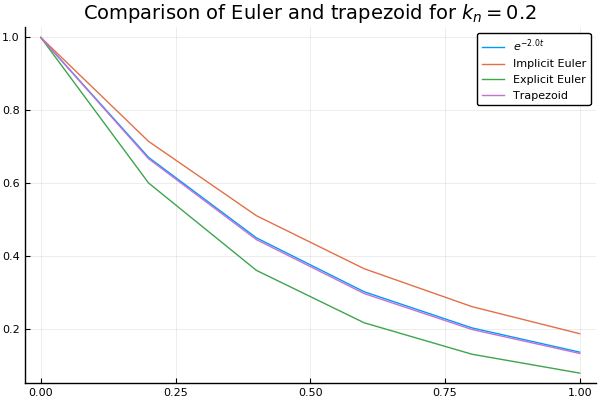

In [217]:
k_n = 0.2
ts = 0:k_n:1

imp_euler = thetamethod(up, ts, u0, 0.0)
trapz = thetamethod(up, ts, u0, 0.5)
exp_euler = thetamethod(up, ts, u0, 1.0)

plot(title = "Comparison of Euler and trapezoid for \$k_n = $k_n\$")
plot!(ts, exp.(λ*ts), label = "\$e^{$λ t}\$")
plot!(ts, imp_euler, label = "Implicit Euler")
plot!(ts, exp_euler, label = "Explicit Euler")
plot!(ts, trapz, label = "Trapezoid")

The theory tells us that the trapezoidal method should have higher accuracy than the
Euler methods, which the above plot also seems to indicate.

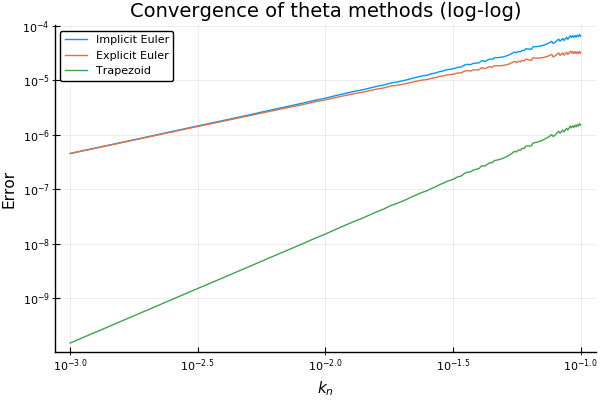

In [218]:
imp_euler_errors = Float64[]
exp_euler_errors = Float64[]
trapz_errors = Float64[]
krange = 0.1:-0.001:0.001
for k = krange
    ts = 0:k:5
    true_val = exp(λ*ts[end])
    push!(imp_euler_errors, abs(thetamethod(up, ts, u0, 0.0)[end]-true_val))
    push!(exp_euler_errors, abs(thetamethod(up, ts, u0, 1.0)[end]-true_val))
    push!(trapz_errors, abs(thetamethod(up, ts, u0, 0.5)[end]-true_val))
end
plot(title = "Convergence of theta methods (log-log)", xlabel = "\$k_n\$", ylabel = "Error", xscale = :log, yscale = :log)
plot!(krange, imp_euler_errors, label = "Implicit Euler")
plot!(krange, exp_euler_errors, label = "Explicit Euler")
plot!(krange, trapz_errors, label = "Trapezoid")

The plot above clearly shows that the trapezoidal method's convergence rate is
faster than the two Euler methods, which seem to converge at the same rate as
expected. The orders also seem correct, as a decrease of a factor $10^{-1}$ in
$k_n$ seems to correspond to a decrease of about a factor $10^{-1}$ of the error
in the Euler methods and a factor $10^{-2}$ in the trapezoidal method.

With $\lambda = -2$, the explicit Euler method should be stable for $k_n < 1$.
The following plot shows the solutions of explicit and implicit Euler for $k_n =
0.5$, $k_n = 0.9$ and $k_n = 1.1$.

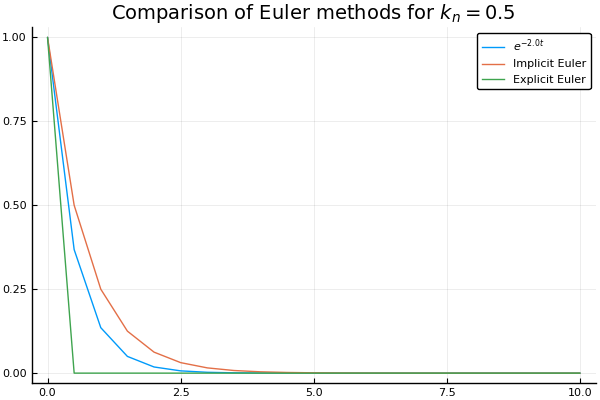

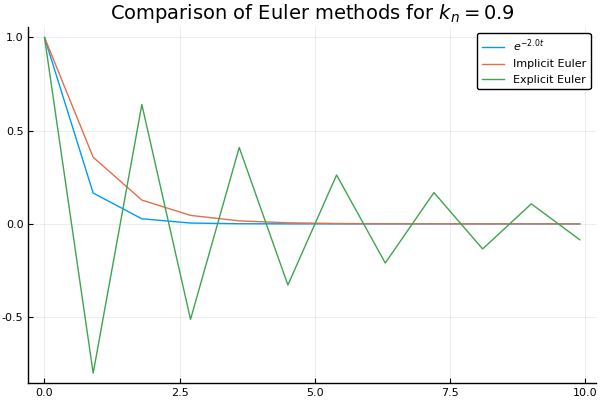

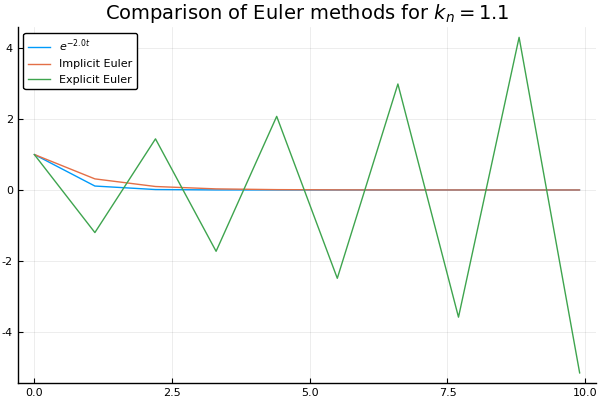

In [212]:
for k_n in [0.5, 0.9, 1.1]
    ts = 0:k_n:10

    imp_euler = thetamethod(up, ts, u0, 0.0)
    exp_euler = thetamethod(up, ts, u0, 1.0)

    plt = plot(title = "Comparison of Euler methods for \$k_n = $k_n\$")
    plot!(ts, exp.(-2ts), label = "\$e^{$λ t}\$")
    plot!(ts, imp_euler, label = "Implicit Euler")
    plot!(ts, exp_euler, label = "Explicit Euler")
    display(plt)
end
closeall()

With $k_n = 0.5$, the solution produced by the explicit Euler method is still
relatively accurate, although farther away than the implicit solution. For $k_n
= 0.9$, the solution is starting to fall apart with large errors, although it
still doesn't blow up. For $k_n = 1.1$, the solution is unstable, the errors
getting larger and larger. All in all, what the plots show seem to be in line
with what theory tells us.

### **System**

As a system of equations is harder to visualize, in this section I only present
plots based on the error in the approximation, as opposed to plots of the actual
approximations.

I use the matrix $A = -\bmatrix{1 & 1 \\ -2 4}$, which has eigenvalues $\lambda_1
= -3, \quad \lambda_2 = -2$. The stability region is  governed by the largest
negative eigenvalue, in this case $-2$, meaning that the explicit Euler method
should be stable for $k_n < 1$.

In [298]:
u0 = [1.0, 1.0]
A = -[1.0 1; -2 4]
up = (u, t) -> A*u

#341 (generic function with 1 method)

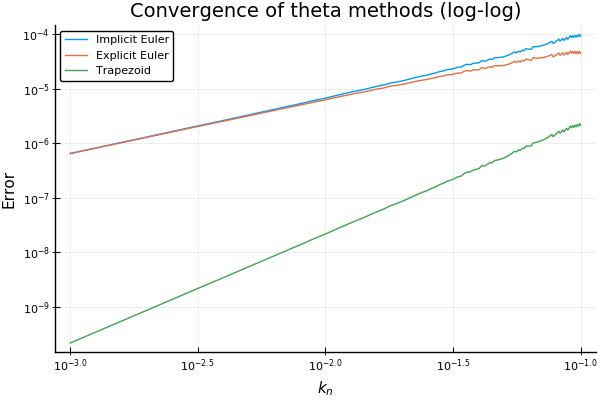

In [299]:
imp_euler_errors = Float64[]
exp_euler_errors = Float64[]
trapz_errors = Float64[]
krange = 0.1:-0.001:0.001
for k = krange
    ts = 0:k:5
    true_val = exp(A*ts[end])*u0
    push!(imp_euler_errors, norm(thetamethod(up, ts, u0, 0.0)[end,:]-true_val))
    push!(exp_euler_errors, norm(thetamethod(up, ts, u0, 1.0)[end,:]-true_val))
    push!(trapz_errors, norm(thetamethod(up, ts, u0, 0.5)[end,:]-true_val))
end
plt = plot(title = "Convergence of theta methods (log-log)", xlabel = "\$k_n\$", ylabel = "Error", xscale = :log, yscale = :log)
plot!(krange, imp_euler_errors, label = "Implicit Euler")
plot!(krange, exp_euler_errors, label = "Explicit Euler")
plot!(krange, trapz_errors, label = "Trapezoid")

We see that the 2x2 system shows the same convergence rates as in the scalar
case. An interesting observation is that the Euler methods have a very large error,
even though the same convergence pattern still holds.

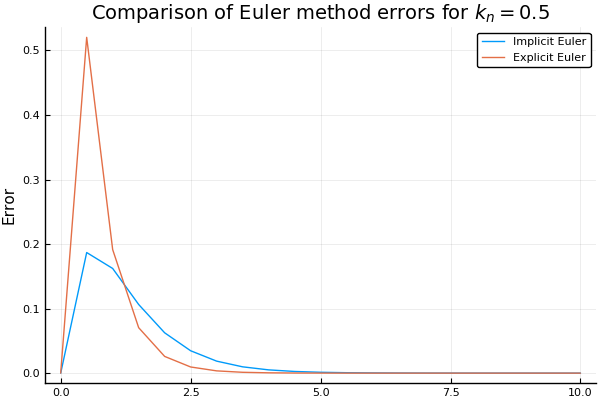

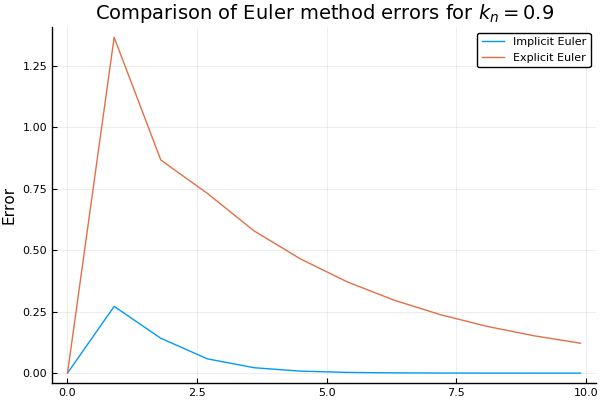

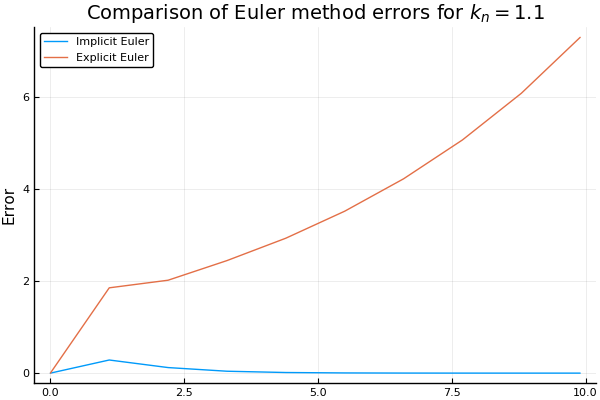

In [306]:
for k_n in [0.5, 0.9, 1.1]
    ts = 0:k_n:10

    actual = hcat([exp(A*t)*u0 for t in ts]...)'
    imp_euler = thetamethod(up, ts, u0, 0.0)
    exp_euler = thetamethod(up, ts, u0, 1.0)
    imp_euler_errors = [norm(actual[i,:]-imp_euler[i,:]) for i in 1:length(ts)]
    exp_euler_errors = [norm(actual[i,:]-exp_euler[i,:]) for i in 1:length(ts)]

    plt = plot(title = "Comparison of Euler method errors for \$k_n = $k_n\$",
        ylabel = "Error")
    plot!(ts, imp_euler_errors, label = "Implicit Euler")
    plot!(ts, exp_euler_errors, label = "Explicit Euler")
    display(plt)
end
closeall()

We see that the same pattern as in the scalar case still holds.

In [14]:
α = 0.2; β = 0.02; γ = 0.7; δ = 0.1

# The system
f(xy, t) = [α*xy[1] - β*xy[1]*xy[2];
            δ*xy[1]*xy[2] - γ*xy[2]]

# Preparing θ-method.
ts = 0.0:0.01:100
xy = [5.; 3.]

2-element Array{Float64,1}:
 5.0
 3.0

In [15]:
# Run method and get results
res = thetamethod(f, ts, xy, 0.0)

10000×2 Array{Float64,2}:
 5.00702   2.99403
 5.01405   2.9881 
 5.02109   2.9822 
 5.02816   2.97633
 5.03524   2.97049
 5.04233   2.96469
 5.04944   2.95892
 5.05657   2.95318
 5.06371   2.94747
 5.07087   2.9418 
 5.07804   2.93615
 5.08523   2.93054
 5.09244   2.92496
 ⋮                
 6.98418  25.1884 
 6.96303  25.1875 
 6.94194  25.186  
 6.92092  25.184  
 6.89997  25.1815 
 6.87909  25.1784 
 6.85828  25.1749 
 6.83753  25.1708 
 6.81685  25.1662 
 6.79625  25.161  
 6.77571  25.1554 
 6.75524  25.1492 

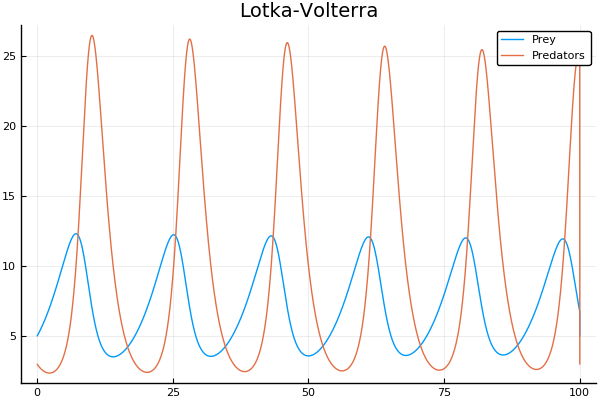

In [16]:
# Plot results
plt = plot(title = "Lotka-Volterra")
plot!(ts, res[:,1], label = "Prey")
plot!(ts, res[:,2], label = "Predators")

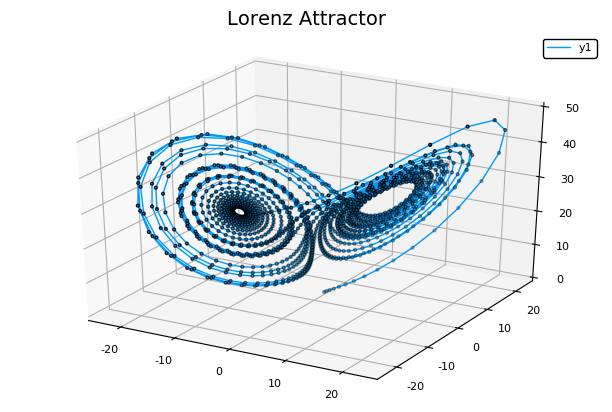

┌ Info: Saved animation to 
│   fn = /home/andersthune/courses/dd2363/DD2363-VT19/Lab-5/tmp.gif
└ @ Plots /home/andersthune/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/home/andersthune/courses/dd2363/DD2363-VT19/Lab-5/tmp.gif")

In [307]:
# TEST, TAKEN FROM THE HOME PAGE OF Plots.jl
# define the Lorenz attractor
mutable struct Lorenz
dt; σ; ρ; β; x; y; z
end

function step!(l::Lorenz)
dx = l.σ*(l.y - l.x)       ; l.x += l.dt * dx
dy = l.x*(l.ρ - l.z) - l.y ; l.y += l.dt * dy
dz = l.x*l.y - l.β*l.z     ; l.z += l.dt * dz
end

attractor = Lorenz((dt = 0.02, σ = 10., ρ = 28., β = 8//3, x = 1., y = 1., z = 1.)...)


# initialize a 3D plot with 1 empty series
plt = plot3d(1, xlim=(-25,25), ylim=(-25,25), zlim=(0,50),
title = "Lorenz Attractor", marker = 2)

# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i=1:1500
step!(attractor)
push!(plt, attractor.x, attractor.y, attractor.z)
end every 10

# **Discussion**

# **References**

- Hoffman, J. 2019. *Introduction to Scientific Computing*
- Wikipedia. *Differential equations* (viewed 2019-02-17). https://en.wikipedia.org/wiki/Trapezoidal_rule_(differential_equations)